# II-2 Privacy Concern

## Data Info
Given the usefulness of the bikeshare datasets the company decided to release a dataset of
scooter rentals that they have aggregated over the past year within Berkeley. The dataset
can be found at https://github.com/ds-102/fa19/tree/master/project/berkeley.csv and has
a very similar format to the chicago.csv, ny.csv, and dc.csv datasets. It includes the zip code
at which the scooter was rented, and the zip code it was dropped off at, the year and birth
month of the renter, and the sex of the renter. The public version also includes the exact
GPS coordinates of scooter pickups and dropoffs but were excluded it here for simplicity.

## Background
Unfortunately a separate dataset was leaked which includes the full name of all the users, <br/>
their month and year of birth, their sex, and the zip code of their address. 
You can find the <br/>leaked file at https://github.com/ds-102/fa19/tree/master/project/leaked.csv. You’ve been
<br/>tasked with investigating the severity of this leak.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import math
%matplotlib inline

In [3]:
## load the data
berkeley_df = pd.read_csv("../data/bikeshare/berkeley.csv")
leak_df = pd.read_csv("../data/bikeshare/leaked.csv")

## 2.1 Exploratory Analysis

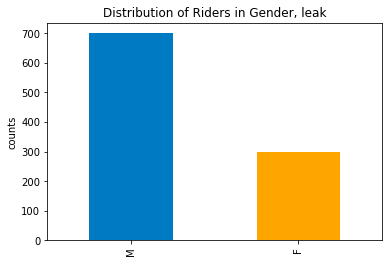

In [36]:
###  Plot the distribution of male to female riders for leaked.csv.
leak_df['sex'].value_counts().plot(kind = "bar", color = ["#007ac2","Orange"])
plt.title("Distribution of Riders in Gender, leak")
plt.ylabel("counts")
plt.show()

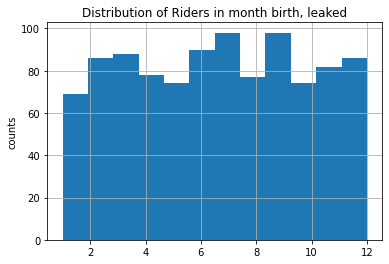

In [9]:
### Plot the distribution of the birth years of bike renters in Leaked
leak_df['month'].hist(bins = 12)
plt.title("Distribution of Riders in month birth, leaked")
plt.ylabel("counts")
plt.show()

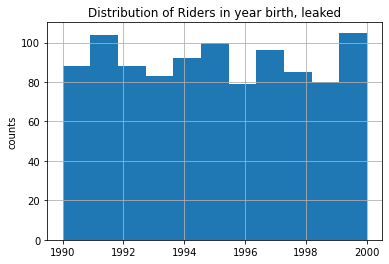

In [8]:
### Plot the distribution of the birth years of bike renters in Leaked
leak_df['year'].hist(bins = 11)
plt.title("Distribution of Riders in year birth, leaked")
plt.ylabel("counts")
plt.show()

In [12]:
# A glance at berkeley.csv
berkeley_df.head()

,sex,month,year,start,end
0,M,12,1999,94704,94704
1,M,12,2000,94706,94706
2,M,4,1999,94703,94703
3,M,2,1999,94710,94710
4,M,12,1994,94707,94707


In [13]:
# A glance at leak_df.csv
leak_df.head()

,name,sex,zip,month,year
0,Avery Phillips,M,94709,3,1993
1,Grayson Rodriguez,M,94705,6,1998
2,Ethan Baker,M,94712,1,1998
3,Carter Wright,M,94720,7,1995
4,Elijah Young,M,94706,2,1996


## 2.2 Simple Proof of Concept

**In this section I will perform a linkage attack given berkeley.csv and leaked.csv. We’ll start with a simpler attack that only uses a subset of the leaked data.**

* Isolate the users from leaked.csv that can be uniquely identified based only on year/month of <br/>birth and their sex. We will call this subset “identifiable users” for the rest of this section.

In [15]:
copy = leak_df.groupby(["sex","month","year"]).count() == 1
copy["unique"] = copy["name"]
print("    # of identifiable user : ", sum(copy["unique"]) ) 

    # of identifiable user :  43


* Plot the number of females and the number of males in the set of identifiable users

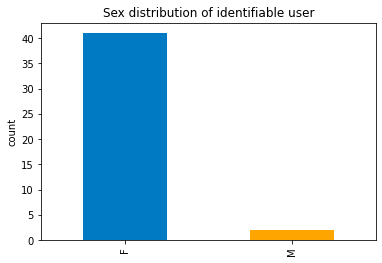

In [28]:
identifiable_users = copy[copy["unique"]]
identifiable_users = identifiable_users.reset_index()

identifiable_users['sex'].value_counts().plot(kind = "bar", color = ["#007ac2","Orange"])
plt.title("Sex distribution of identifiable user")
plt.ylabel("count")
plt.show()

**The sex distribution doesn't match. The sex distribution of identifiable user is very different from the 2.1 (sex distribution of leaked.csv).** 
<br/><br/>The potential reasons are:
* Most "identifiable user" in the leaked.csv are female, because in overall, the total quantity of female user is less than male user. Therefore, female users are more "identifiable" with other information given combined with the fact that they are female. 
* This may happen because Scooters are in general less popular among female riders, so once they rent the scooters, those records are very "identifiable".

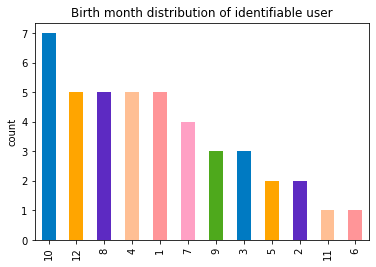

In [37]:
## Plot the distribution of birth months for identifiable user
identifiable_users['month'].value_counts().plot(kind = "bar", color = ["#007ac2","Orange","#5d2ac2","#ffbf94","#ff9598","#ffa0c4","#4ea91c"])
plt.title("Birth month distribution of identifiable user")
plt.ylabel("count")
plt.show()

**It doesn't match the birth month of identifiable user is distributed not so uniform as in 2.1 (birth month of all leaked user).** 
<br/><br/> It makes sense that in October it has most identifiable user as there are most leaked user in October. Though this distribution is not so uniform, if we look at it carefully, the gap between the highest column and lowest  column is only 5 count. It's likely that this "non-uniform" is due to the small sample size, since "identifiable user" are a group of 43 samples out of 1000 data.

**For each identifiable user, extract the scooter rentals they have made from berkeley.csv.**

In [41]:
berkeley_df["user_count"] = berkeley_df.groupby(["sex","month","year"])["sex"].transform("count")

## store the leaked combination
identifiable_comb = identifiable_users[["sex","month","year"]]

## aggregate the berkeley_df by their user_count, identified by [sex month year], there are 255 in total
temp = berkeley_df.groupby(["sex","month","year"])[['sex']].count()
temp.columns = ['rentals_made']
temp.reset_index(inplace = True)

## match to those in the lead comb
new_df = pd.merge(temp, identifiable_comb, on = ["sex","month","year"], how = 'right')

### how many rentals each identifiable users make
new_df.head(43)

,sex,month,year,rentals_made
0,F,1,1991,35
1,F,1,1992,92
2,F,1,1995,68
3,F,1,1998,62
4,F,1,1999,15
5,F,2,1990,36
6,F,2,1995,58
7,F,3,1992,10
8,F,3,1995,67
9,F,3,1999,82


* Now, to extract the scooter rentals these people made in berkeley.csv, **simply match their ["sex" "month" "year"]**, and count how many records are found **corresponding to each ["sex" "month" "year"] combination**. <br/><br/>
* The quantity of rides of each "identifiable user" made in berkeley.csv is displayed in the data frame **above**. Similar method can be applied to extract the record made by each "identifiable user" in berkeley.csv.

## 2.3 A More Elaborate Attack
* In this section, a more elaborate linkage attack that makes use of the zip code information will be conducted.
* Assume that users will tend to rent scooters with start and end location with the same zip code as their address. 
* Users will **rent a bike from another (uniformly sampled) zip code with probability $p_{1}$**, similarly users will end a **rental at a different zip code from their address with probability $p_{2}$**. In other words the distribution on whether a user will start or end a rental at a zip code different from their address is given by **Bern($p_{1}$)** and **Bern($p_{2}$)** respectively.

### 2.3.1 estimating $p_{1}$, $p_{2}$
* I first match the "identifiable user" with berkeley.csv, then whoever matches on <br/>"sex" "month" "year" are the theoretical identifiable users. These people's info can <br/>be fully recovered if berkeley.csv has their home zip code, and there are 2205 of them.  


* Now, to estimate $p_{1}$ and $p_{1}$, with the identifiable users from the leak.csv like 2.2,<br/>and matches these people with the data in berkeley.csv. Since the identifiable users' <br/>home zip code are provided, we have the following dataframe displayed.  


* Therefore, we can finally estimate p1 by seeing how many people have a "start zip code" <br/>(start column in leak_sample) different from "home zip code"(zip column in leak_sample); <br/>and similarly, estimate p2 by seeing how many people have a "end zip code"(end column in <br/>leak_sample) different from "home zip code"(zip column in leak_sample).


In [42]:
leak_sample = pd.merge(leak_df, berkeley_df, on = ["sex","month","year"])
leak_sample = pd.merge(leak_sample, identifiable_users[["sex","month","year"]], on = ["sex","month","year"])
leak_sample.head()

,name,sex,zip,month,year,start,end,user_count
0,Emily Phillips,F,94702,1,1995,94702,94702,68
1,Emily Phillips,F,94702,1,1995,94702,94702,68
2,Emily Phillips,F,94702,1,1995,94702,94702,68
3,Emily Phillips,F,94702,1,1995,94708,94702,68
4,Emily Phillips,F,94702,1,1995,94702,94702,68


In [44]:
### trips that start somewhere not home
p1_hat = np.sum(leak_sample["start"] != leak_sample["zip"])/len(leak_sample)
### trips that end somewhere not home
p2_hat = np.sum(leak_sample["end"] != leak_sample["zip"])/len(leak_sample)

* With all procedures above proceeded,     
  $\hat p_1 = 0.0965$,    
  $\hat p_2 = 0.278$

### 2.3.2 generate 95% confidence interval

The randomness of the estimate of $p_{1}$ and $p_{2}$ come from only 2205 of data are used to estimate $p_{1}$ and $p_{2}$, since only these people's home zip is "leaked". <br/><br/>
To get the confidence of interval of $p_{1}$ and $p_{2}$, we'll calculate the estimated variance of $p_{1}$ and $p_{2}$ by applying the unbiased estimator formula of variance,    

$S^2 = \frac{1}{n-1}\sum_{i = 1}^{n}(y_i - \bar y)^2$,  

Then, to get a better bound for p1 and p2, since they are bounded variables in [0,1]. I apply Hoeffding bound to further restrict the range they lie in.  

To be more specific, here's how we derived it for this Bernouli distribution:  

$P(|\bar y - p| \geq t) \leq 2e^{-2nt^2}$    

$P(|\bar y - p| < t) \geq 1 - 2e^{-2nt^2}$    

If we want 95% confidence interval, set right hand side to 0.95 and solve for t, we get,    

$t = \sqrt{-\frac{1}{2n}\log{0.025}}$, 
rewrite the confidence interval, we have,  

$P(\quad\bar y - \sqrt{-\frac{1}{2n}\log{0.025}} < p < \bar y + \sqrt{-\frac{1}{2n}\log{0.025}}\quad )\geq 0.95$.

In summary, 

$\hat p_1 = 0.09659$, with 95% confidence interval [0.06767, 0.12552];  

$\hat p_2 = 0.27800$, with 95% confidence interval [0.24908, 0.30692].

The calculation procedures are given below.

In [45]:
print(np.std(leak_sample["start"] != leak_sample["zip"]))
print(np.std(leak_sample["end"] != leak_sample["zip"]))

0.29541046411912036
0.4480156398886925


In [47]:
### for p1
t = math.sqrt((-1/4410)*math.log(0.025))
l_bound = p1_hat - t
u_bound = p1_hat + t
print(l_bound)
print(u_bound)
print("confidence interval of p1: [0.06767, 0.12552]")

0.06767666507919635
0.1255206138323683
confidence interval of p1: [0.06767, 0.12552]


In [46]:
### for p2
t = math.sqrt((-1/4410)*math.log(0.025))
l_bound = p2_hat - t
u_bound = p2_hat + t
print(l_bound)
print(u_bound)
print("confidence interval of p2: [0.24908, 0.30692]")

0.24908256077080637
0.30692650952397826
confidence interval of p2: [0.24908, 0.30692]


### 2.3.3 & 2.3.4 Theoretically Identifiable Users

In [48]:
theo_iden_users = pd.merge(identifiable_users[["sex","month","year"]], berkeley_df, on = ["sex","month","year"])
len(theo_iden_users)

2205

* There are 2205 theoretically identifiable users if berkeley csv also provide home <br/>zip code for each user. I do this by matching the identifiable users' info with the <br/>berkekley.csv's record.

### 2.3.5 Algorithm for return the most likely user given a specific trip

1. Given a trip, look at the combined information ["sex" "month" "year"] of the trip, and see if it's in the "identifiable user" group. If yes, then return the corresponding user information from the "identifiable user"; if not, run the following steps.  


2. Include one more variable "start" into the combined information ["sex" "month" "year" "start"] to the given trip. Assume "start" is the home address of the user, and matches the information in Leak.csv with ["sex" "month" "year" "zip"], this should return a bunch of users. For each of these users, there's on average a $1-\hat p_1$ chance for each user to be exactly the user idenitified in Leak.csv, store this probability as a_1. 


3. Similarly, include another variable "end" into the combined information ["sex" "month" "year" "end"] to the given trip. Assume "end" is the home address of the user, and matches the information in Leak.csv with ["sex" "month" "year" "zip"], this should return another bunch of users. For each of these users, there's on average a $1-\hat p_2$ chance for each user to be exactly the user idenitified in Leak.csv, store this probability as a_2.


4. Add up a_1, a_2 for each user, the user with highest sum of a_1 and a_2(may be more than one) will be the most likely user given a trip. If more than one user have the highest sum, we'll randomly return one of them or return all of them depends on the needs.

## 2.4 Takeaways 

- Privacy can be leaked unintentionally, name and date of birth is not the only way to   
uniquely identify a person's identity. When a user hardly rent a scooter, the risk of  
being "identified" is higher, because there's more "uniqueness" for this group of people.   
Once the privacy is leaked, it's hardly recoverable.



- Let the users whose information is leaked create a new account for scooter rentals,   
and release the data in a more private way in the future, so that the trip information   
of users in the future won't be "hacked"; For the "theoretical identifiable users", don't   
release their home zip ever in the future.   



- When releasing the dataset, besides erasing sensitive information, like name and date   
of birth, we shall also think of if any combination of the data in the dataset can uniquely  
identify a person. Also, before releasing a dataset, take consideration of the data that   
had been released.  
If there's anything similar that's already released, be more careful since if the two dataset   
are similar then privacy might get "hacked" by simply matching the information between   
two dataset.